# **Research Project (Honours)**

###### *By Mahlatsi Malise Mashilo (202215639)*

### **Forecasting Car Sales in South Africa Using Google Search Data with Post-hoc Explainable AI**
##### *Model Building Notebook*

## 1. Libraries

In [5]:
! pip install pandas numpy matplotlib scikit-learn seaborn plotly statsmodels shap joblib openpyxl prophet lightgbm EMD-signal tensorflow

  Using cached numpy-1.23.5-cp310-cp310-win_amd64.whl.metadata (2.3 kB)
INFO: pip is looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.
Using cached numpy-1.23.5-cp310-cp310-win_amd64.whl (14.6 MB)
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.7 MB 5.6 MB/s eta 0:00:01
   ----------- ---------------------------- 0.8/2.7 MB 2.4 MB/s eta 0:00:01
   ---------------------- ----------------- 1.6/2.7 MB 2.6 MB/s eta 0:00:01
   ------------------------------ --------- 2.1/2.7 MB 2.6 MB/s eta 0:00:01
   ---------------------------------- ----- 2.4/2.7 MB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 2.3 MB/s  0:00:01
   ---------------------------------------- 0.0/37.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/37.9 MB ? eta -:--:--
    --------------------------------------- 0.8/37.9 MB 2.2 MB

In [6]:
import itertools
import logging
import random
import pandas as pd, numpy as np, seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from PyEMD import EEMD

import os, joblib
import openpyxl

import tensorflow as tf

import keras
from pathlib import Path

from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")
from scipy.signal import windows, savgol_filter
from scipy.stats import boxcox, norm

# Deep learning
from keras.models import Sequential
from keras.layers import GRU, LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Bidirectional

from prophet import Prophet
# Disable Prophet logs
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

import lightgbm as lgb
# Optional: Disable LightGBM info messages
lgb.basic_config = {'verbose': -1}

from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# SARIMA, LSSVR
import statsmodels.api as sm
from sklearn.svm import SVR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [7]:
# Reproducibility Setup
SEED = 42

# Python random seed
random.seed(SEED)

# NumPy seed
np.random.seed(SEED)

# TensorFlow seed
tf.random.set_seed(SEED)

# For reproducibility in TensorFlow (disable nondeterministic ops)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

# Disable TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## 2. Importing Final Datasts

In [32]:
# Folder containing the datasets
input_folder = Path("final_datasets")

# Dictionary to hold the loaded DataFrames
loaded_dfs = {}

# Loop through all Excel files except 'final_df.xlsx'
for file in input_folder.glob("*.xlsx"):
    if file.name == "final_df.xlsx":
        continue
    
    # Use the filename without extension as the variable name
    var_name = file.stem
    loaded_dfs[var_name] = pd.read_excel(file, index_col=0)  # preserve index if any

# Optionally, assign to variables in global namespace (careful with this in scripts)
globals().update(loaded_dfs)

# Check loaded DataFrames
print("Loaded datasets:")
for name, df in loaded_dfs.items():
    print(f"- {name}: {df.shape}")

Loaded datasets:
- X1_test: (42, 1)
- X1_train: (213, 1)
- X2_test: (42, 10)
- X2_train: (214, 10)
- y1_test: (42, 1)
- y1_train: (213, 1)
- y2_test: (42, 1)
- y2_train: (214, 1)


In [33]:
# Folder containing the scalers
input_folder = Path("final_scalers")

# Load fitted scalers back
X1_scaler = joblib.load(input_folder / "X1_scaler.pkl")
X2_scaler = joblib.load(input_folder / "X2_scaler.pkl")
y1_scaler = joblib.load(input_folder / "y1_scaler.pkl")
y2_scaler = joblib.load(input_folder / "y2_scaler.pkl")

print("Scalers loaded successfully.")

Scalers loaded successfully.


## 3. Ensemble Empirical Mode Decomposition (EEMD)

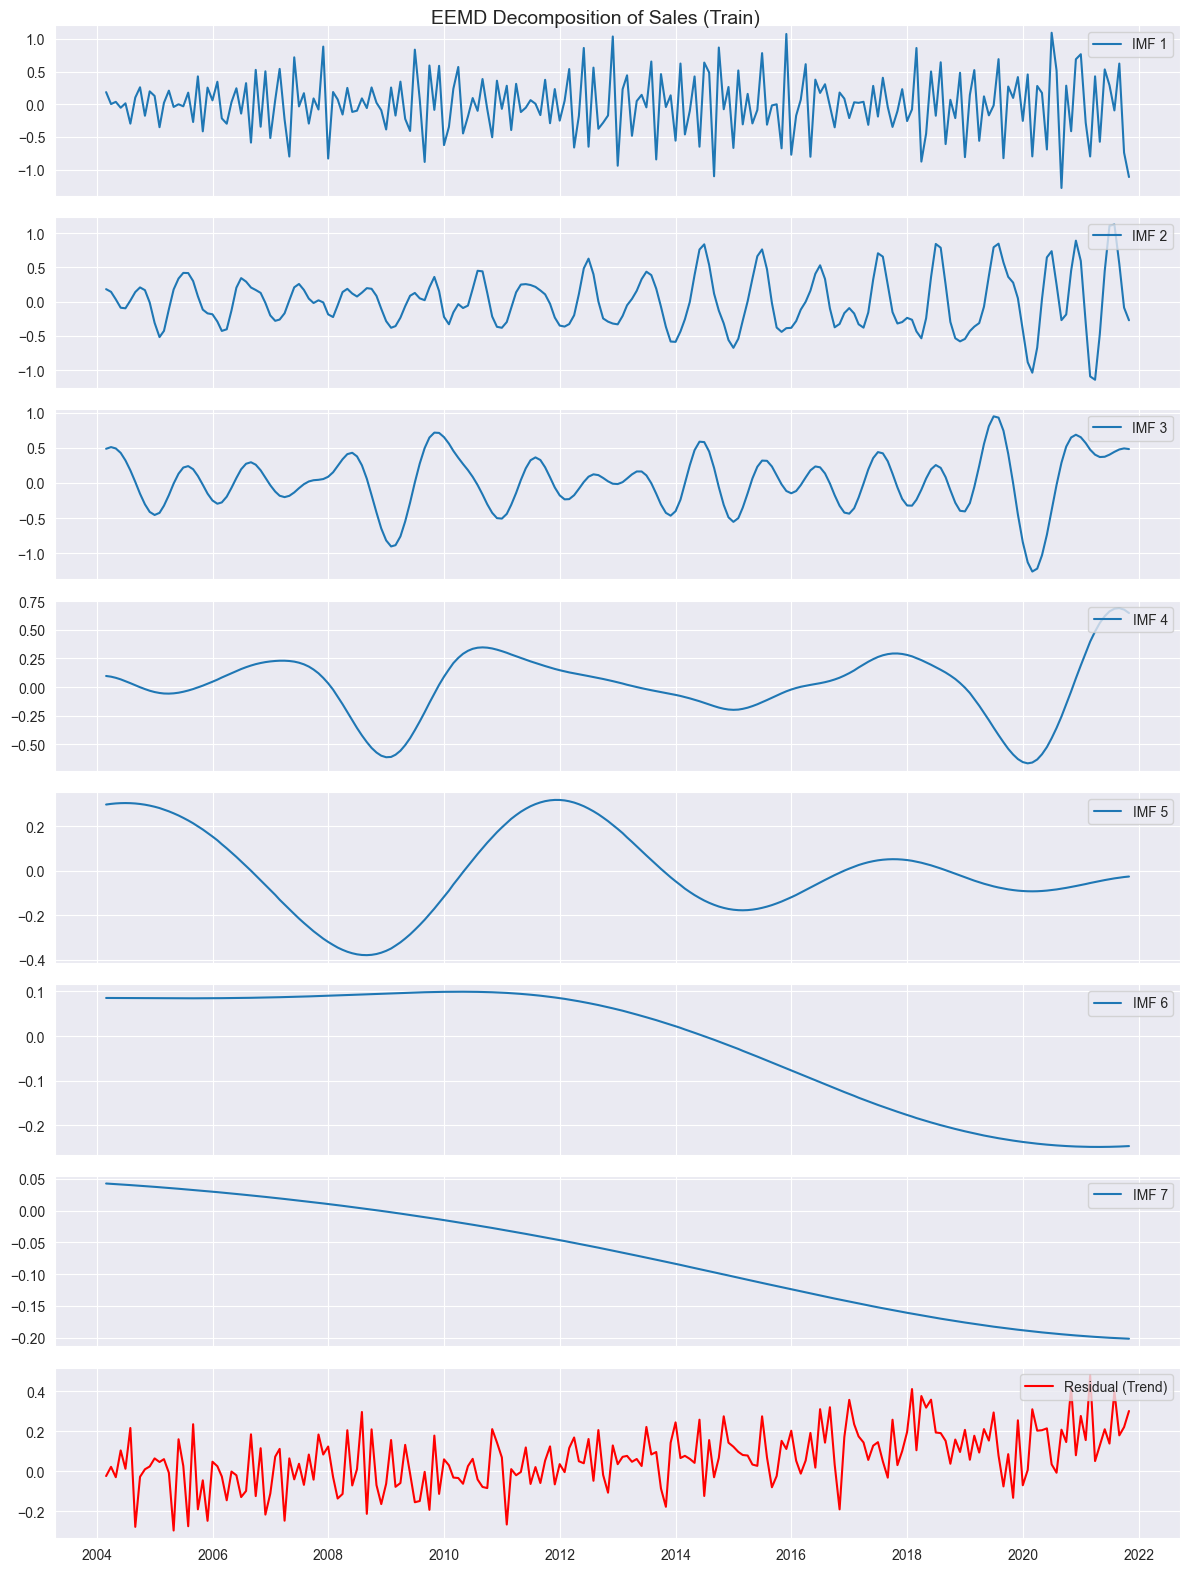

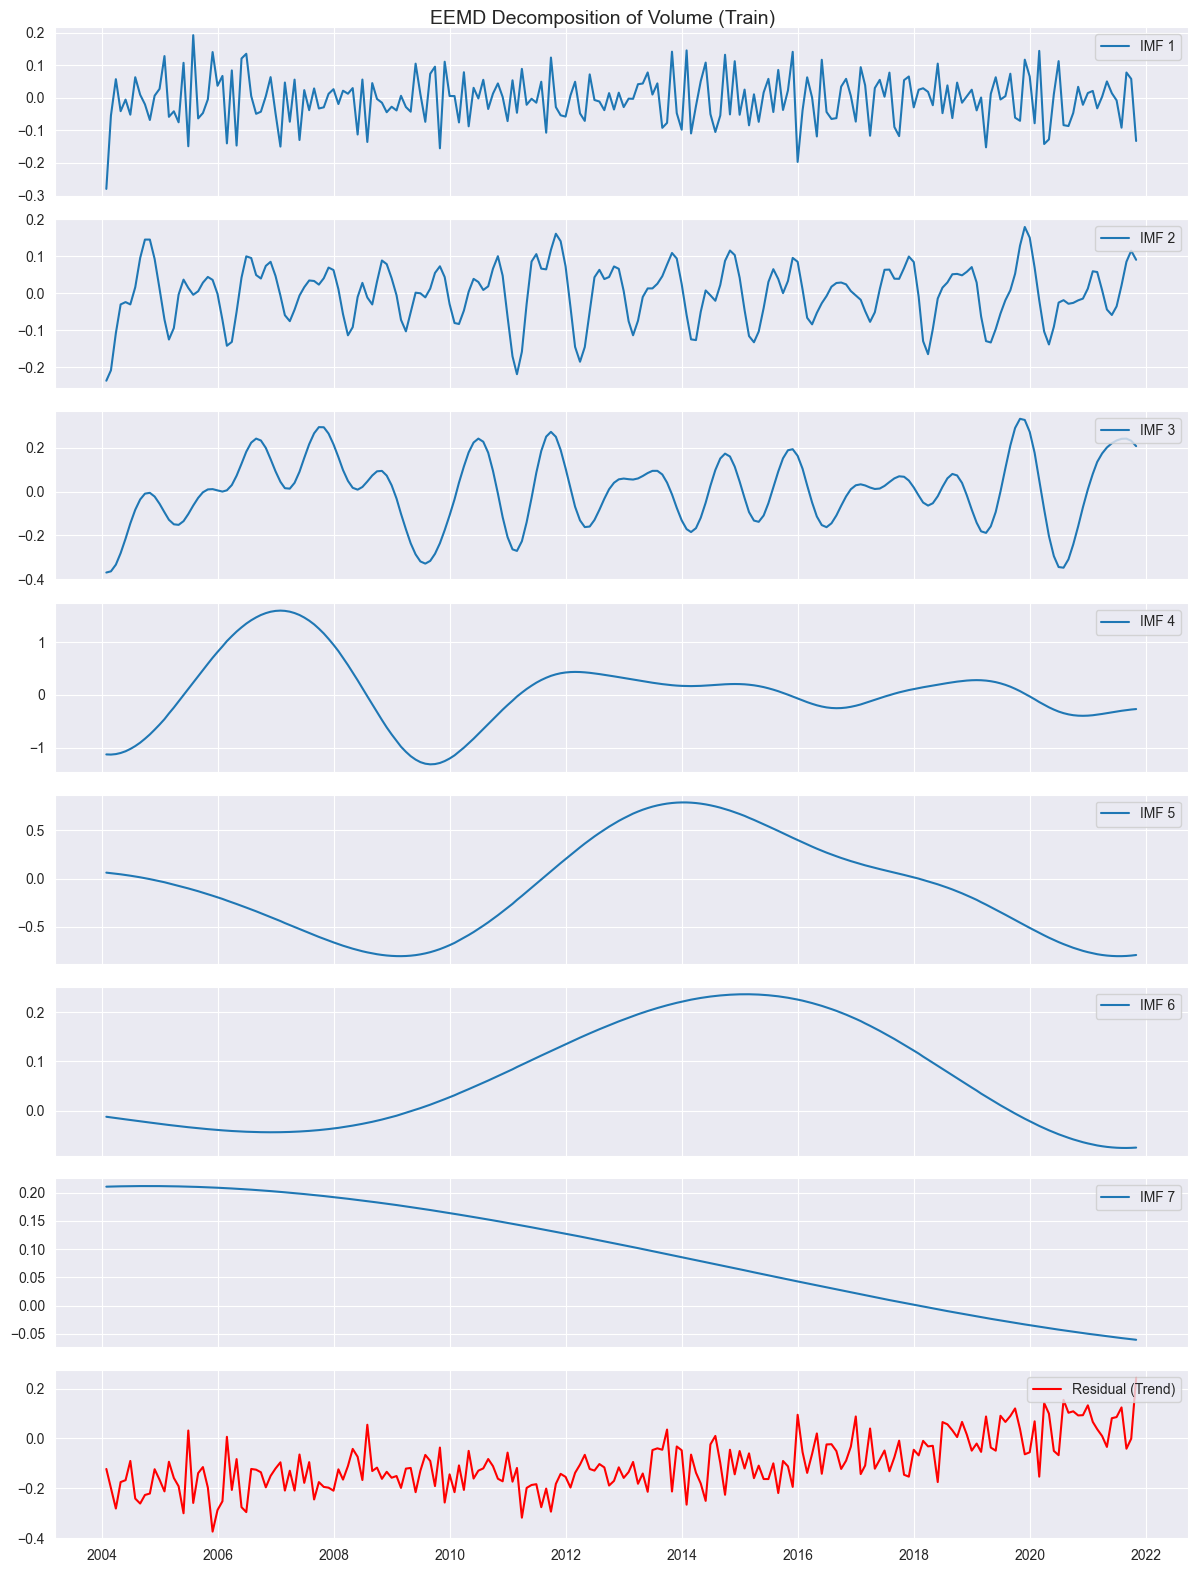

In [34]:
# === EEMD to create Intrinsic Mode Functions (IMFs) ===
def run_eemd(series, series_name="Series", noise_width=0.2, n_ensembles=100, max_imf=8, plot=True):
    """
    Decompose training series using EEMD.
    Returns IMFs (n_imfs, len(series)) and residual.
    """
    eemd = EEMD()
    eemd.noise_width = noise_width
    eemd.trials = n_ensembles

    series = series.dropna()
    X = series.values.flatten()
    t = np.arange(len(series))

    imfs = eemd.eemd(X, t, max_imf)
    residual = X - np.sum(imfs, axis=0)

    if plot:
        n_imfs = imfs.shape[0]
        fig, axes = plt.subplots(n_imfs+1, 1, figsize=(12, 2*(n_imfs+1)), sharex=True)
        for i in range(n_imfs):
            axes[i].plot(series.index, imfs[i], label=f'IMF {i+1}')
            axes[i].legend(loc='upper right')
        axes[-1].plot(series.index, residual, label="Residual (Trend)", color="red")
        axes[-1].legend(loc='upper right')
        plt.suptitle(f"EEMD Decomposition of {series_name}", fontsize=14)
        plt.tight_layout()
        plt.show()

    return imfs, residual


# Example decomposition
sales_imfs, sales_residual = run_eemd(y1_train, "Sales (Train)")
volume_imfs, volume_residual = run_eemd(y2_train, "Volume (Train)")

eemd_results = {
    "sales": {"imfs": sales_imfs, "residual": sales_residual},
    "volume": {"imfs": volume_imfs, "residual": volume_residual}
}


## 4. Lag Selection and ARX Preparation

In [39]:
# === Lagged Feature Creator ===
def create_features(y_train, y_test, X_train, X_test, lags, series_name):
    """Generate lagged features + align train/test with exogenous features."""
    # Train lags
    lagged_train = pd.DataFrame(index=y_train.index)
    for lag in range(1, lags + 1):
        lagged_train[f"{series_name}_lag{lag}"] = y_train.shift(lag)
    X_train = pd.concat([lagged_train, X_train], axis=1).dropna()
    y_train = y_train.loc[X_train.index]

    # Test lags (use last lags from train to seed)
    combined = pd.concat([y_train.tail(lags), y_test])
    lagged_test = pd.DataFrame(index=combined.index)
    for lag in range(1, lags + 1):
        lagged_test[f"{series_name}_lag{lag}"] = combined.shift(lag)
    lagged_test = lagged_test.iloc[lags:]
    
    X_test = pd.concat([lagged_test.reset_index(drop=True),
                        X_test.reset_index(drop=True)], axis=1)
    y_test = y_test.reset_index(drop=True).iloc[:len(X_test)]

    return X_train, X_test, y_train, y_test


# Apply with correct lag structure
X1_train_lagged, X1_test_lagged, y1_train_lagged, y1_test_lagged = create_features(y1_train, y1_test, X1_train, X1_test, lags=1, series_name="Sales")
X2_train_lagged, X2_test_lagged, y2_train_lagged, y2_test_lagged = create_features(y2_train, y2_test, X2_train, X2_test, lags=2, series_name="Volume")

## 4. Modelling

The plan is to investigate the effect of search data on the sales and volume using 5 different models. These models are given below:

<table style="width:100%">
  <thead>
    <tr>
      <th>Model</th>
      <th>Description</th>
      <th>Model Category</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>SARIMA / SARIMAX</td>
      <td>Captures linear seasonality and trend but limited in handling nonlinear patterns.</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LSSVR</td>
      <td>Least Squares SVM regression. Strong at capturing nonlinear relationships, though it requires careful hyperparameter tuning.</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LSTM</td>
      <td>Sequential neural model for time series. Learns long-term dependencies and nonlinearities but can be computationally heavy.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>BiLSTM</td>
      <td>Captures both forward and backward dependencies in sequences, offering richer temporal context than unidirectional LSTM.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>CNN-LSTM</td>
      <td>Combines CNN (local feature extraction) with LSTM (temporal learning). Effective for complex time series with both short- and long-term dependencies.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>GRU</td>
      <td>A simplified version of LSTM with fewer parameters. Trains faster while retaining the ability to model temporal dependencies.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>Prophet</td>
      <td>Additive time series model developed by Facebook. Designed for business forecasting, handles seasonality, holidays, and missing data robustly.</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LightGBM</td>
      <td>Gradient boosting framework optimized for speed and efficiency. Handles high-dimensional data well, supports feature importance analysis, and is strong at capturing nonlinear interactions.</td>
      <td>Machine Learning</td>
    </tr>
  </tbody>
</table>


### a. Helper Functions

In [64]:
# === Evaluation ===
def evaluate_model(y_true, y_pred, model_name="Model",
                   fitted_model=None, conf_int=None, k=None):
    """
    Compute metrics (RMSE, MAE, MAPE, R2, AIC, BIC) directly on y_true and y_pred.
    Returns both metrics dict (rounded to 3 decimals) and DataFrame with predictions.
    """
    # Align indexes
    if hasattr(y_true, "index"):
        index = y_true.index
        y_true = y_true.values.flatten()
    else:
        index = pd.RangeIndex(start=0, stop=len(y_true))
        y_true = np.array(y_true).flatten()

    y_pred = np.array(y_pred).flatten()

    # Residuals
    residuals = y_true - y_pred
    rss, n = np.sum(residuals**2), len(y_true)

    # Metrics
    rmse = np.sqrt(rss / n)
    mae = np.mean(np.abs(residuals))
    mape = np.mean(np.abs(residuals / (y_true + 1e-10)))
    r2 = 1 - rss / np.sum((y_true - np.mean(y_true))**2)

    # AIC/BIC
    aic, bic = np.nan, np.nan
    if fitted_model is not None and hasattr(fitted_model, "aic") and hasattr(fitted_model, "bic"):
        aic, bic = fitted_model.aic, fitted_model.bic
    else:
        if k is None:
            k = 1
        aic = n * np.log(rss / n) + 2 * k
        bic = n * np.log(rss / n) + k * np.log(n)

    # Confidence intervals
    if conf_int is not None:
        ci_lower, ci_upper = conf_int[:, 0], conf_int[:, 1]
    else:
        ci_lower, ci_upper = np.full_like(y_pred, np.nan), np.full_like(y_pred, np.nan)

    df = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
        "ci_lower": ci_lower,
        "ci_upper": ci_upper
    }, index=index)

    metrics = {
        "Model": model_name,
        "RMSE": round(rmse, 3),
        "MAE": round(mae, 3),
        "MAPE": round(mape, 3),
        "R2": round(r2, 3),
        "AIC": round(aic, 3) if not np.isnan(aic) else np.nan,
        "BIC": round(bic, 3) if not np.isnan(bic) else np.nan
    }
    return metrics, df


# === Classical & ML Models ===
def train_sarimax(y_train, X_train=None, order=(1,1,0), seasonal_order=(0,0,0,0)):
    """SARIMAX (or ARIMA if X_train=None)."""
    model = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
    return model.fit(disp=False)

def train_lightgbm(X_train, y_train, params=None):
    """LightGBM regressor."""
    if params is None:
        params = {"objective": "regression", "n_estimators": 200, "learning_rate": 0.05}
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    return model

def train_lssvr(X_train, y_train, C=1.0, gamma="scale"):
    """Approximate LSSVR with sklearn SVR."""
    model = SVR(C=C, gamma=gamma)
    model.fit(X_train, y_train)
    return model


# === Prophet ===
def train_prophet(y_train, X_train=None):
    """Prophet with or without exogenous regressors."""
    df = y_train.reset_index()
    df.columns = ["ds", "y"]
    model = Prophet()
    if X_train is not None:
        for col in X_train.columns:
            model.add_regressor(col)
        df = pd.concat([df, X_train.reset_index(drop=True)], axis=1)
    model.fit(df)
    return model


# === Deep Learning Builders ===
def build_lstm(input_shape, units=64):
    model = Sequential([
        LSTM(units, activation="tanh", input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss="mse")
    return model

def build_bilstm(input_shape, units=64):
    model = Sequential([
        Bidirectional(LSTM(units, activation="tanh"), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss="mse")
    return model

def build_gru(input_shape, units=64):
    model = Sequential([
        GRU(units, activation="tanh", input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss="mse")
    return model

def build_cnn_lstm(input_shape):
    timesteps = input_shape[0]
    kernel = 2 if timesteps >= 2 else 1
    model = Sequential([
        Conv1D(filters=64, kernel_size=kernel, activation="relu", input_shape=input_shape),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model


# === DL Training with Recursive Forecasting ===
def train_deep_model(model_fn, X_train, y_train, X_test, y_test,
                     epochs=50, batch_size=16, recursive=True):
    """
    Train deep learning model (LSTM, GRU, etc.) with option for recursive multi-step forecasting.
    """
    # Handle DataFrame or np.array
    if hasattr(X_train, "values"):
        X_train_values, X_test_values = X_train.values, X_test.values
        feature_names = list(X_train.columns)
    else:
        X_train_values, X_test_values = X_train, X_test
        feature_names = [f"f{i}" for i in range(X_train.shape[1])]

    n_samples, n_features = X_train_values.shape
    timesteps = max(1, sum("lag" in f for f in feature_names))

    # Reshape into 3D [samples, timesteps, features_per_step]
    X_train_3d = X_train_values.reshape((n_samples, timesteps, n_features // timesteps))
    X_test_3d  = X_test_values.reshape((X_test_values.shape[0], timesteps, n_features // timesteps))

    # Build & fit model
    model = model_fn(input_shape=(X_train_3d.shape[1], X_train_3d.shape[2]))
    model.fit(X_train_3d, y_train, validation_data=(X_test_3d, y_test),
              epochs=epochs, batch_size=batch_size, verbose=0)

    if not recursive:
        # Direct prediction
        y_pred = model.predict(X_test_3d).flatten()
    else:
        # Recursive multi-step prediction
        y_pred = []
        last_window = X_train_3d[-1]  # last observed window from training
        for t in range(len(y_test)):
            yhat = model.predict(last_window.reshape(1, *last_window.shape), verbose=0).flatten()[0]
            y_pred.append(yhat)

            # Update window: shift left and insert new prediction in lag position
            new_features = last_window.copy()
            new_features[:-1, :] = new_features[1:, :]
            new_features[-1, 0] = yhat  # update target lag
            last_window = new_features

        y_pred = np.array(y_pred)

    return model, y_pred

# === Updated run_all_models ===
def run_all_models(y_train, y_test, X_train=None, X_test=None, label="",
                   recursive_dl=True, eemd_parts=None):
    """
    Train/evaluate SARIMAX, LightGBM, LSSVR, Prophet, LSTM, BiLSTM, GRU, CNN-LSTM
    on raw data or EEMD-decomposed components.
    For EEMD, all models use IMF lagged features + residual as regressors.
    """
    local_results, local_pred_dfs = [], {}

    # ------------------------
    # Prepare EEMD features if provided
    # ------------------------
    if eemd_parts is not None:
        imfs, residual = eemd_parts["imfs"], eemd_parts["residual"]
    
        # Build DataFrame of IMFs + residual
        imf_list = []
        for i in range(imfs.shape[0]):
            imf_series = pd.Series(imfs[i][:len(y_train)], index=y_train.index, name=f"{label}_IMF{i+1}")
            imf_list.append(imf_series)
        imf_df = pd.concat(imf_list, axis=1)
        imf_df[f"{label}_Residual"] = residual[:len(y_train)]
    
        # 1-lag features
        imf_lagged = imf_df.shift(1)
        X_train = pd.concat([X_train, imf_lagged], axis=1).iloc[1:]
        y_train = y_train.iloc[1:]
    
        # X_test: seed with last row from train, then lagged test features
        imf_test_seed = imf_df.tail(1)
        imf_test_shifted = pd.concat([imf_test_seed, imf_df.shift(1).iloc[1:]], axis=0).iloc[:len(y_test)]
        X_test = pd.concat([X_test.reset_index(drop=True), imf_test_shifted.reset_index(drop=True)], axis=1)


    # ------------------------
    # Standard training for all models
    # ------------------------

    # === SARIMAX ===
    sarimax_model = train_sarimax(y_train, X_train, order=(1,1,0), seasonal_order=(0,0,0,0))
    sarimax_forecast = sarimax_model.get_forecast(steps=len(y_test), exog=X_test)
    sarimax_pred = sarimax_forecast.predicted_mean
    sarimax_ci = sarimax_forecast.conf_int()
    metrics, df = evaluate_model(
        y_test, sarimax_pred, f"SARIMAX-{label}",
        fitted_model=sarimax_model,
        conf_int=sarimax_ci.values,
        k=None if X_train is None else X_train.shape[1]
    )
    local_results.append(metrics)
    local_pred_dfs[f"SARIMAX-{label}"] = df

    # === LightGBM ===
    Xtr = X_train.values if hasattr(X_train, "values") else X_train
    Xte = X_test.values if hasattr(X_test, "values") else X_test
    lgbm_model = train_lightgbm(Xtr, y_train)
    lgbm_pred = lgbm_model.predict(Xte)
    metrics, df = evaluate_model(
        y_test, lgbm_pred, f"LightGBM-{label}",
        k=Xtr.shape[1]
    )
    local_results.append(metrics)
    local_pred_dfs[f"LightGBM-{label}"] = df

    # === LSSVR ===
    lssvr_model = train_lssvr(Xtr, y_train)
    lssvr_pred = lssvr_model.predict(Xte)
    metrics, df = evaluate_model(
        y_test, lssvr_pred, f"LSSVR-{label}",
        k=Xtr.shape[1]
    )
    local_results.append(metrics)
    local_pred_dfs[f"LSSVR-{label}"] = df

    # === Prophet ===
    prophet_model = train_prophet(y_train, X_train)
    future = pd.DataFrame({"ds": pd.to_datetime(y_test.index)})
    if X_test is not None:
        for col in X_test.columns:
            future[col] = X_test[col].values
    prophet_forecast = prophet_model.predict(future)
    prophet_pred = prophet_forecast["yhat"].values
    prophet_ci = prophet_forecast[["yhat_lower", "yhat_upper"]].values
    metrics, df = evaluate_model(
        y_test, prophet_pred, f"Prophet-{label}",
        conf_int=prophet_ci,
        k=None if X_train is None else Xtr.shape[1]
    )
    local_results.append(metrics)
    local_pred_dfs[f"Prophet-{label}"] = df

    # === Deep Learning models ===
    dl_models = {
        "LSTM": build_lstm,
        "BiLSTM": build_bilstm,
        "GRU": build_gru,
        "CNN-LSTM": build_cnn_lstm,
    }
    for name, builder in dl_models.items():
        dl_model, dl_pred = train_deep_model(
            builder, Xtr, y_train, Xte, y_test,
            epochs=30, batch_size=16,
            recursive=recursive_dl
        )
        metrics, df = evaluate_model(
            y_test, dl_pred, f"{name}-{label}",
            k=Xtr.shape[1]
        )
        local_results.append(metrics)
        local_pred_dfs[f"{name}-{label}"] = df

    return local_results, local_pred_dfs

### b. Sales

#### i. Model Training

In [65]:
# === Sales Experiments (Baseline, Exogenous, EEMD) ===
results = []
sales_pred_dfs = {}

# ------------------------------------------------------
# 1. Baseline (lags only)
# ------------------------------------------------------
baseline_results, baseline_dfs = run_all_models(
    y1_train_lagged, y1_test_lagged,
    X_train=X1_train_lagged[["Sales_lag1"]], X_test=X1_test_lagged[["Sales_lag1"]],
    label="Sales-Baseline",
    recursive_dl=True
)
results.extend(baseline_results)
sales_pred_dfs.update(baseline_dfs)

# ------------------------------------------------------
# 2. Exogenous (lags + extra regressors)
# ------------------------------------------------------
exo_results, exo_dfs = run_all_models(
    y1_train_lagged, y1_test_lagged,
    X_train=X1_train_lagged,
    X_test=X1_test_lagged,
    label="Sales-Exogenous",
    recursive_dl=True
)
results.extend(exo_results)
sales_pred_dfs.update(exo_dfs)

# ------------------------------------------------------
# 3. EEMD-enhanced (IMFs + residual forecasting)
# ------------------------------------------------------
eemd_results_, eemd_dfs = run_all_models(
    y1_train_lagged, y1_test_lagged,
    X_train=X1_train_lagged,   # still allow exogenous regressors
    X_test=X1_test_lagged,
    label="Sales-EEMD",
    eemd_parts=eemd_results["sales"],
    recursive_dl=True
)
results.extend(eemd_results_)
sales_pred_dfs.update(eemd_dfs)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 212, number of used features: 1
[LightGBM] [Info] Start training from score -0,006394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

06:26:42 - cmdstanpy - INFO - Chain [1] start processing
06:26:42 - cmdstanpy - INFO - Chain [1] done processing
06:27:32 - cmdstanpy - INFO - Chain [1] start processing


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97
[LightGBM] [Info] Number of data points in the train set: 212, number of used features: 2
[LightGBM] [Info] Start training from score -0,006394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

06:27:32 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 211, number of used features: 10
[LightGBM] [Info] Start training from score -0,012114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

06:28:10 - cmdstanpy - INFO - Chain [1] start processing
06:28:10 - cmdstanpy - INFO - Chain [1] done processing


#### ii. Results

In [66]:
# ------------------------------------------------------
# Final results
# ------------------------------------------------------
sales_results_df = pd.DataFrame(results)
sales_results_df

,Model,RMSE,MAE,MAPE,R2,AIC,BIC
0,SARIMAX-Sales-Baseline,180.573,180.243,1.170,-569.130,530.103,540.159
1,LightGBM-Sales-Baseline,153.490,153.305,0.996,-410.936,424.826,426.563
2,LSSVR-Sales-Baseline,154.814,154.628,1.004,-418.072,425.547,427.285
3,Prophet-Sales-Baseline,62.915,61.848,0.404,-68.211,349.910,351.647
4,LSTM-Sales-Baseline,154.038,153.853,0.999,-413.880,425.125,426.862
5,BiLSTM-Sales-Baseline,154.054,153.869,0.999,-413.968,425.134,426.871
6,GRU-Sales-Baseline,154.090,153.905,0.999,-414.162,425.153,426.891
7,CNN-LSTM-Sales-Baseline,154.042,153.857,0.999,-413.904,425.127,426.865
8,SARIMAX-Sales-Exogenous,185.895,185.525,1.204,-603.227,529.243,542.650
9,LightGBM-Sales-Exogenous,153.639,153.454,0.997,-411.733,426.907,430.382


In [67]:
sales_pred_dfs["GRU-Sales-EEMD"]

,y_true,y_pred,ci_lower,ci_upper
0,133.381897,0.303321,NaN,NaN
1,134.646513,0.401615,NaN,NaN
2,136.297326,0.445607,NaN,NaN
3,138.186034,0.465176,NaN,NaN
4,139.716576,0.473856,NaN,NaN
5,141.879650,0.477701,NaN,NaN
6,145.553939,0.479404,NaN,NaN
7,149.690199,0.480157,NaN,NaN
8,153.815278,0.480491,NaN,NaN
9,155.403374,0.480638,NaN,NaN


### c. Volume

#### i. Model Training

In [ ]:
# === volume Experiments (Baseline, Exogenous, EEMD) ===
results = []
volume_pred_dfs = {}

# ------------------------------------------------------
# 1. Baseline (lags only)
# ------------------------------------------------------
baseline_results, baseline_dfs = run_all_models(y2_train, y2_test,
                                                label="Baseline")
results.extend(baseline_results)
volume_pred_dfs.update(baseline_dfs)

# ------------------------------------------------------
# 2. Exogenous (lags + extra regressors)
# ------------------------------------------------------
exo_results, exo_dfs = run_all_models(y2_train, y2_test,
                                      X_train=X2_train,
                                      X_test=X2_test,
                                      label="Exogenous")
results.extend(exo_results)
volume_pred_dfs.update(exo_dfs)

# ------------------------------------------------------
# 3. EEMD-enhanced (lags + regressors + IMFs/residual)
# ------------------------------------------------------
volume_imfs, volume_resid = eemd_results["volume"]["imfs"], eemd_results["volume"]["residual"]

# Align IMFs to lagged training series
imf_cols = [f"IMF{i+1}" for i in range(volume_imfs.shape[0])]
eemd_train = pd.DataFrame(
    volume_imfs[:, -len(y2_train):].T,
    index=y2_train.index,
    columns=imf_cols
)
eemd_train["Residual"] = volume_resid[-len(y2_train):]

# Test features (repeat last known value)
eemd_test = pd.DataFrame(index=y2_test.index, columns=eemd_train.columns)
for col in eemd_train.columns:
    eemd_test[col] = eemd_train[col].iloc[-1]

# Combine with original X features
X2_train_eemd = pd.concat([X2_train, eemd_train], axis=1).fillna(0)
X2_test_eemd  = pd.concat([X2_test, eemd_test], axis=1).fillna(0)

# Remove constant columns
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=1e-5)
selector.fit(X2_train_eemd)
X2_train_eemd = X2_train_eemd[X2_train_eemd.columns[selector.get_support()]]
X2_test_eemd  = X2_test_eemd[X2_test_eemd.columns[selector.get_support()]]

# Run models
eemd_results_, eemd_dfs = run_all_models(y2_train, y2_test,
                                         X_train=X2_train_eemd,
                                         X_test=X2_test_eemd,
                                         label="EEMD")
results.extend(eemd_results_)
volume_pred_dfs.update(eemd_dfs)

#### ii. Results

In [ ]:
# ------------------------------------------------------
# Final results
# ------------------------------------------------------
volume_results_df = pd.DataFrame(results)
volume_results_df


=== Univariate Sales Prediction Results ===


,model,aic,bic,rmse,mape,mae,r2
0,SARIMA,53.45,58.51,0.93,0.84,16.08,-9.42
1,LSSVR-Uni,29.84,31.53,0.48,0.37,3.07,-1.76
2,LSTM-Uni,151.84,256.55,0.74,0.67,13.66,-5.61
3,BiLSTM-Uni,196.93,301.64,1.65,1.53,30.53,-31.43
4,CNN-LSTM-Uni,308.98,521.78,0.96,0.83,8.57,-10.08
5,GRU-Uni,170.34,275.05,1.08,0.99,19.06,-12.90
6,PROPHET-Uni,24.73,29.79,0.31,0.24,3.54,-0.12
7,LIGHTGBM-Uni,69.11,89.38,1.04,0.95,18.64,-12.03
8,SARIMA-Uni_EEMD,67.50,72.56,1.38,1.28,22.94,-21.66
9,LSSVR-Uni_EEMD,43.92,64.18,0.61,0.53,12.55,-3.47


In [ ]:
print("\n=== Example of Forecast Datasets ===")
volume_forecast_dfs_uni["LSTM-Uni_Volume_forecast_results"].info()